In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule

In [2]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

print(y_test[:10])

[3 8 8 0 6 6 1 6 3 1]


In [3]:
# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


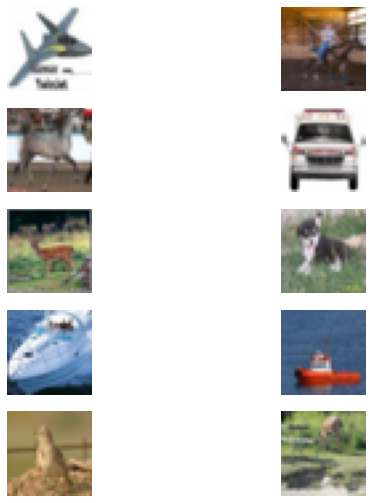

In [4]:
# show some random pics

show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)
x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(show_n // 2, 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    col_idx = 1 - int(idx % 2 == 0)
    ax = axs[idx // 2, col_idx]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [5]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [6]:
print(np.mean(x_train, axis=0))
print(np.mean(x_train, axis=0).shape)
print(np.std(x_train, axis=0))
print(x_train.shape)

print(np.mean(x_val, axis=0))
print(np.std(x_val, axis=0))

print(np.mean(x_test, axis=0))
print(np.std(x_test, axis=0))

print(y_train.shape)
print(y_train.shape[0])

[ 1.14188659e-15 -6.18216589e-16  8.90314489e-15 ...  5.31555910e-15
  8.26625435e-15  1.97581895e-14]
(3072,)
[1. 1. 1. ... 1. 1. 1.]
(10000, 3072)
[-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
[0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
[-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
[0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]
(10000,)
10000


In [ ]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_train.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_train])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_val.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_val])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

In [ ]:
def eval_numerical_gradient(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [ ]:
def eval_numerical_gradient_double(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxph = f(x) # evalute f(x + h)
        
        x[ix] = old_value - h # decrease by h
        fxmh = f(x) # evalute f(x - h)
        x[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        grad[ix] = (fxph - fxmh) / (2*h) # the slope
        it.iternext() # step to next dimension

    return grad

In [ ]:
def loss(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return loss

def grad(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return dW

In [ ]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
    return loss(x_train[:2], y_train[:2], W)

W = np.random.rand(3072, 10) * 0.001 # random weight vector
df = eval_numerical_gradient_double(CIFAR10_loss_fun, W) # get the gradient

In [ ]:
df_ana = grad(x_train[:2], y_train[:2], W)

In [ ]:
v = np.abs(df_ana - df)/(np.maximum(np.abs(df_ana), np.abs(df)))

In [ ]:
v

In [ ]:
np.testing.assert_array_almost_equal(df, df_ana, decimal=6)

In [ ]:
print(np.max(v))
assert np.all(v < 10e-5)

In [ ]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.0001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_train.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_train].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(num_examples), y_train] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_val.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_val].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_val] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_batch.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_batch].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_batch] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        

        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(num_examples),y_batch] -= valid_margin_count
        
        dW = np.dot(x_batch.T, margin) / num_examples #? why divide
        
        dW += reg*W
        
        db = np.sum(margin, axis=0, keepdims=True)
        
        """num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient"""


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

In [11]:
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate_l2 = 1.0

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **init_params), 
          bias_initializer=NormalInitializer(seed=None, **init_params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=LinearActivation()
         )

layers = [
    dense_1
]

model = Model(layers)
print(model)

loss = CategoricalHingeLoss()

lr_initial = 0.0001
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial))

n_epochs = 10#40
batch_size = 100

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x N(0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x N(0.0, 0.01^2)
	 activation: linear


starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 204.71it/s]
epoch 1/10 
 	 -- train loss = 7.2837523740301275, train accuracy = 0.2809 
	 -- val loss = 7.508565733922665, val accuracy = 0.2684 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 184.88it/s]
epoch 2/10 
 	 -- train loss = 6.762675275538584, train accuracy = 0.3144 
	 -- val loss = 7.054416242997555, val accuracy = 0.2976 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 191.42it/s]
epoch 3/10 
 	 -- train loss = 6.482614766963845, train accuracy = 0.3364 
	 -- val loss = 6.814996081252598, val accuracy = 0.3138 


starting epoch: 4 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 173.69it/s]
epoch 4/10 
 	 -- train loss = 6.305061751320291, train accuracy = 0.3491 
	 -- val loss = 6

In [12]:
def plot_losses(history):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_accuracies(history):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
def plot_lr(history):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    plt.show()
    
#plot_losses(history)
#plot_accuracies(history)
#plot_lr(history)

In [ ]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    The function is taken from: https://cs231n.github.io/
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


def viz_kernel(w, im_shape, figsize=(8,8)):
    
    w = w.reshape(im_shape + (-1,)).transpose(3, 0, 1, 2)
    plt.figure(figsize=figsize)
    plt.imshow(visualize_grid(w, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

w = model.get_trainable_weights()[-1]["w"]
im_shape=(32,32,3)
viz_kernel(w, im_shape)

## 2 Layers

data batch 1.mat
for training, the file data batch 2.mat for validation and the file test batch.mat
for testing

model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 71.12it/s]
epoch 1/50 
 	 -- train loss = 2.1739447519719906, train accuracy = 0.3423 
	 -- val loss = 2.2362409495946407, val accuracy = 0.3156 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 72.13it/s]
epoch 2/50 
 	 -- train loss = 1.9777183764622521, train accuracy = 0.412 
	 -- val loss = 2.0985958107418066, val accuracy = 0.3618 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 71.96it/s]
epoch 3/50 
 	 -- train loss = 1.8238065057889687, train accuracy = 0.4625 
	 -- val loss = 2.003861550725477, val accuracy = 0.394 


starting epoch: 4 ...

batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 80.58it/s]
epoch 36/50 
 	 -- train loss = 1.1796742254186028, train accuracy = 0.7009 
	 -- val loss = 2.084060961378959, val accuracy = 0.4288 


starting epoch: 37 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 85.55it/s]
epoch 37/50 
 	 -- train loss = 1.2313260171154812, train accuracy = 0.675 
	 -- val loss = 2.112309957210368, val accuracy = 0.4231 


starting epoch: 38 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 82.34it/s]
epoch 38/50 
 	 -- train loss = 1.2895243254390942, train accuracy = 0.6517 
	 -- val loss = 2.0993712150775745, val accuracy = 0.4268 


starting epoch: 39 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 77.76it/s]
epoch 39/50 
 	 -- train loss = 1.3164690500423677, train accuracy = 0.6343 
	 -- val loss = 2.0941561655717336, val accuracy = 0.4102 


starting epoch: 40 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 80.73it/s]
epoch 40/50 
 	 -- train loss = 1.

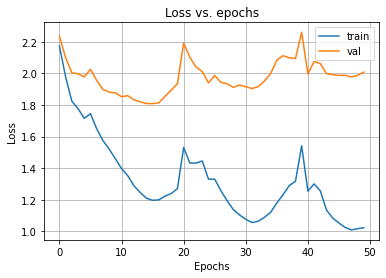

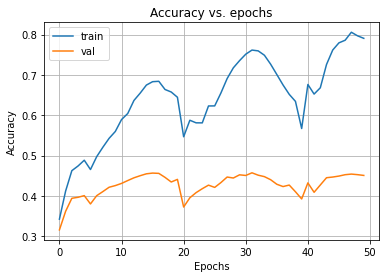

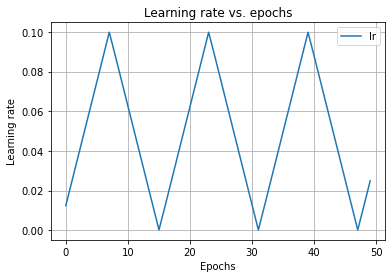

In [18]:
coeff = 1.0
mean = 0.0
std = 0.01
params_xav = {"coeff":coeff, "mean": mean, "std":None}
params_norm = {"coeff":coeff, "mean": mean, "std": std}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.01

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params_xav), 
          bias_initializer=XavierInitializer(seed=seed+1, **params_xav), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params_xav), 
          bias_initializer=XavierInitializer(seed=seed+3, **params_xav), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 50
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)
plot_lr(history)